# Exploratory Data Analysis

## 1. Loading and cleaning data

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import dataframe as dfr
import data_transforms as dtr
import plot

I will start by loading the dataset's `csv` file into a `Pandas` dataframe, and taking a look at the first few lines.
As explained in the README file, the .csv file was extracted from the database where the data was stored. To extract this data I used a separate script: **db_Extraction.py**.

In [2]:
df = pd.read_csv('loan_payments.csv')

#Pandas setting to show all columns when displaying data:
pd.set_option('display.max_columns', None)

df.head()

id  member_id  loan_amount  funded_amount  funded_amount_inv  \
0  38676116   41461848         8000         8000.0             8000.0   
1  38656203   41440010        13200        13200.0            13200.0   
2  38656154   41439961        16000        16000.0            16000.0   
3  38656128   41439934        15000        15000.0            15000.0   
4  38656121   41439927        15000        15000.0            15000.0   

        term  int_rate  instalment grade sub_grade employment_length  \
0  36 months      7.49      248.82     A        A4           5 years   
1  36 months      6.99      407.52     A        A3           9 years   
2  36 months      7.49      497.63     A        A4           8 years   
3  36 months     14.31      514.93     C        C4            1 year   
4  36 months      6.03      456.54     A        A1         10+ years   

  home_ownership  annual_inc verification_status issue_date loan_status  \
0       MORTGAGE     46000.0        Not Verified   Jan-2021     Current   
1           RENT     50000.0        Not Verified   Jan-2021     Current   
2       MORTGAGE     73913.0     Source Verified   Jan-2021  Fully Paid   
3           RENT     42000.0     Source Verified   Jan-2021  Fully Paid   
4       MORTGAGE    145000.0            Verified   Jan-2021     Current   

  payment_plan             purpose    dti  delinq_2yrs earliest_credit_line  \
0            n         credit_card  19.54            2             Oct-1987   
1            n         credit_card  24.20            0             Sep-2001   
2            n         credit_card  16.92            0             Sep-1998   
3            n  debt_consolidation  35.52            0             Jun-2008   
4            n  debt_consolidation   3.33            0             Apr-2002   

   inq_last_6mths  mths_since_last_delinq  mths_since_last_record  \
0               1                     5.0                     NaN   
1               0                     NaN                     NaN   
2               0                    69.0                     NaN   
3               0                    74.0                     NaN   
4               1                    37.0                     NaN   

   open_accounts  total_accounts  out_prncp  out_prncp_inv  total_payment  \
0             12              27    5529.70        5529.70        2982.51   
1             15              31    9102.83        9102.83        4885.11   
2              7              18       0.00           0.00       16824.54   
3              6              13       0.00           0.00       15947.47   
4             23              50   10297.47       10297.47        5473.46   

   total_payment_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  \
0            2982.51          2470.30         512.21                 0.0   
1            4885.11          4097.17         787.94                 0.0   
2           16824.54         16000.00         824.54                 0.0   
3           15947.47         15000.00         947.47                 0.0   
4            5473.46          4702.53         770.93                 0.0   

   recoveries  collection_recovery_fee last_payment_date  last_payment_amount  \
0         0.0                      0.0          Jan-2022               248.82   
1         0.0                      0.0          Jan-2022               407.52   
2         0.0                      0.0          Oct-2021             12850.16   
3         0.0                      0.0          Jun-2021             13899.67   
4         0.0                      0.0          Jan-2022               456.54   

  next_payment_date last_credit_pull_date  collections_12_mths_ex_med  \
0          Feb-2022              Jan-2022                         0.0   
1          Feb-2022              Jan-2022                         0.0   
2               NaN              Oct-2021                         0.0   
3               NaN              Jun-2021                         0.0   
4          Feb-2022     

The data appear to adhere to the [Tidy](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) principle, which is good news.

In tidy data:
- Each variable forms a column
- Each observation forms a row
- Each type of observational unit forms a table

In our case, we can see that each row corresponds to a single customer, and each column corresponds to a descriptive feature of the loan pertaining to that customer.

We can tell there are at least some `NaN`s in there, which we will need to decide how to handle.

We can also see that most of the data types are numeric in nature, though some appear to be continuous (eg. `loan_amount`), while others appear to be categorical, either ordinal (eg. `grade` ) or nominal/Boolean (eg. `home_ownership`). There are also dates (eg. `issue_date`) in the dataset.

Finally, we can see that some columns may not show correct data types. For example, the data stored in column "term" is likely to be stored as a string.
We will check the data types below:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54231 entries, 0 to 54230
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           54231 non-null  int64  
 1   member_id                    54231 non-null  int64  
 2   loan_amount                  54231 non-null  int64  
 3   funded_amount                51224 non-null  float64
 4   funded_amount_inv            54231 non-null  float64
 5   term                         49459 non-null  object 
 6   int_rate                     49062 non-null  float64
 7   instalment                   54231 non-null  float64
 8   grade                        54231 non-null  object 
 9   sub_grade                    54231 non-null  object 
 10  employment_length            52113 non-null  object 
 11  home_ownership               54231 non-null  object 
 12  annual_inc                   54231 non-null  float64
 13  verification_sta

The above shows us that some of the data types are wrong (for example, "term" could be a numeric data type and all columns containing dates are stored as object). The code below transforms the data to appropiate data types so later we can analyse it.

I created my own python module to apply formatting to the dataframe. The module is called dataframe.py and the advantage of coding it this way is that the module can be reused for future projects.

In [4]:
columns_to_integer = ['funded_amount', 'funded_amount_inv']
dfr.DataFrameTransform().format_to_integer(df, columns_to_integer)

columns_to_string = ['grade', 'sub_grade', 'application_type']
dfr.DataFrameTransform().format_to_string(df, columns_to_string)

columns_to_datatime = ['issue_date', 'earliest_credit_line', 'last_payment_date', 'next_payment_date', 'last_credit_pull_date']
dfr.DataFrameTransform().format_to_datetime(df, columns_to_datatime)

dfr.DataFrameTransform().format_remove_suffix(df, 'term', ' months')

dfr.DataFrameTransform().format_to_mapping(df, 'employment_length', 'employment_length_dict.yaml')

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54231 entries, 0 to 54230
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           54231 non-null  int64         
 1   member_id                    54231 non-null  int64         
 2   loan_amount                  54231 non-null  int64         
 3   funded_amount                51224 non-null  float64       
 4   funded_amount_inv            54231 non-null  int64         
 5   term                         49459 non-null  float64       
 6   int_rate                     49062 non-null  float64       
 7   instalment                   54231 non-null  float64       
 8   grade                        54231 non-null  string        
 9   sub_grade                    54231 non-null  string        
 10  employment_length            52113 non-null  float64       
 11  home_ownership               54231 non-nu

id  member_id  loan_amount  funded_amount  funded_amount_inv  term  \
0  38676116   41461848         8000         8000.0               8000  36.0   
1  38656203   41440010        13200        13200.0              13200  36.0   
2  38656154   41439961        16000        16000.0              16000  36.0   
3  38656128   41439934        15000        15000.0              15000  36.0   
4  38656121   41439927        15000        15000.0              15000  36.0   

   int_rate  instalment grade sub_grade  employment_length home_ownership  \
0      7.49      248.82     A        A4                5.0       MORTGAGE   
1      6.99      407.52     A        A3                9.0           RENT   
2      7.49      497.63     A        A4                8.0       MORTGAGE   
3     14.31      514.93     C        C4                1.0           RENT   
4      6.03      456.54     A        A1               10.0       MORTGAGE   

   annual_inc verification_status issue_date loan_status payment_plan  \
0     46000.0        Not Verified 2021-01-01     Current            n   
1     50000.0        Not Verified 2021-01-01     Current            n   
2     73913.0     Source Verified 2021-01-01  Fully Paid            n   
3     42000.0     Source Verified 2021-01-01  Fully Paid            n   
4    145000.0            Verified 2021-01-01     Current            n   

              purpose    dti  delinq_2yrs earliest_credit_line  \
0         credit_card  19.54            2           1987-10-01   
1         credit_card  24.20            0           2001-09-01   
2         credit_card  16.92            0           1998-09-01   
3  debt_consolidation  35.52            0           2008-06-01   
4  debt_consolidation   3.33            0           2002-04-01   

   inq_last_6mths  mths_since_last_delinq  mths_since_last_record  \
0               1                     5.0                     NaN   
1               0                     NaN                     NaN   
2               0                    69.0                     NaN   
3               0                    74.0                     NaN   
4               1                    37.0                     NaN   

   open_accounts  total_accounts  out_prncp  out_prncp_inv  total_payment  \
0             12              27    5529.70        5529.70        2982.51   
1             15              31    9102.83        9102.83        4885.11   
2              7              18       0.00           0.00       16824.54   
3              6              13       0.00           0.00       15947.47   
4             23              50   10297.47       10297.47        5473.46   

   total_payment_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  \
0            2982.51          2470.30         512.21                 0.0   
1            4885.11          4097.17         787.94                 0.0   
2           16824.54         16000.00         824.54                 0.0   
3           15947.47         15000.00         947.47                 0.0   
4            5473.46          4702.53         770.93                 0.0   

   recoveries  collection_recovery_fee last_payment_date  last_payment_amount  \
0         0.0                      0.0        2022-01-01               248.82   
1         0.0                      0.0        2022-01-01               407.52   
2         0.0                      0.0        2021-10-01             12850.16   
3         0.0                      0.0        2021-06-01             13899.67   
4         0.0                      0.0        2022-01-01               456.54   

  next_payment_date last_credit_pull_date  collections_12_mths_ex_med  \
0        2022-02-01            2022-01-01                         0.0   
1        2022-02-01            2022-01-01                         0.0   
2               NaT            2021-10-01                         0.0   
3               NaT            2021-06-01                         0.0   
4        2022-02-01            2022-01-01       

Next, let's check the dataset for `null` values. The quickest way to do this is also with the `df.info()` method. However care should be taken using this method for non-numeric columns, as there are many other ways for text data to end up scrambled without being a true `null` value.

From the output above, we can  see that there are 54231 rows and observing the Non-Null column, we can see that some columns are missing data.
In the next lines of code, I will drop the columns where percentage of missing data is too high to impute values. Let's obtain the percentages of null values for each column:

In [5]:
# Generate a count/percentage count of NULL values in each column:
print(df.isnull().sum()/len(df)*100)

id                              0.000000
member_id                       0.000000
loan_amount                     0.000000
funded_amount                   5.544799
funded_amount_inv               0.000000
term                            8.799395
int_rate                        9.531449
instalment                      0.000000
grade                           0.000000
sub_grade                       0.000000
employment_length               3.905515
home_ownership                  0.000000
annual_inc                      0.000000
verification_status             0.000000
issue_date                      0.000000
loan_status                     0.000000
payment_plan                    0.000000
purpose                         0.000000
dti                             0.000000
delinq_2yrs                     0.000000
earliest_credit_line            0.000000
inq_last_6mths                  0.000000
mths_since_last_delinq         57.166565
mths_since_last_record         88.602460
open_accounts   

In this case, I will assume any column with more that 10% of missing data is too high to impute. These columns are:
- `mths_since_last_delinq`
- `mths_since_last_record`
- `next_payment_date`
- `mths_since_last_major_derog`

None of these columns will be relevant to understand the state of the loans, so it is safe to remove these columns from the dataset:

In [6]:
list_columns_missing_data =['mths_since_last_delinq','mths_since_last_record','next_payment_date','mths_since_last_major_derog']
df = dtr.DataTransform().remove_columns(df, list_columns_missing_data)

For the columns where we are missing a small percentage of data (below 10%) my aim will be to impute the missing data. These columns are:
- `funded_amount` numerical data
- `int_rate` numerical data
- `term` categorical data 
- `employment_length` categorical data

And for the below columns where we are missing less than 1% data, I will drop the rows with missing data as this will not have a relevant impact on the analysis:
- `last_payment_date` date data
- `last_credit_pull_date` date data
- `collections_12_mths_ex_med` numerical data

First, let's visualise the missing data:

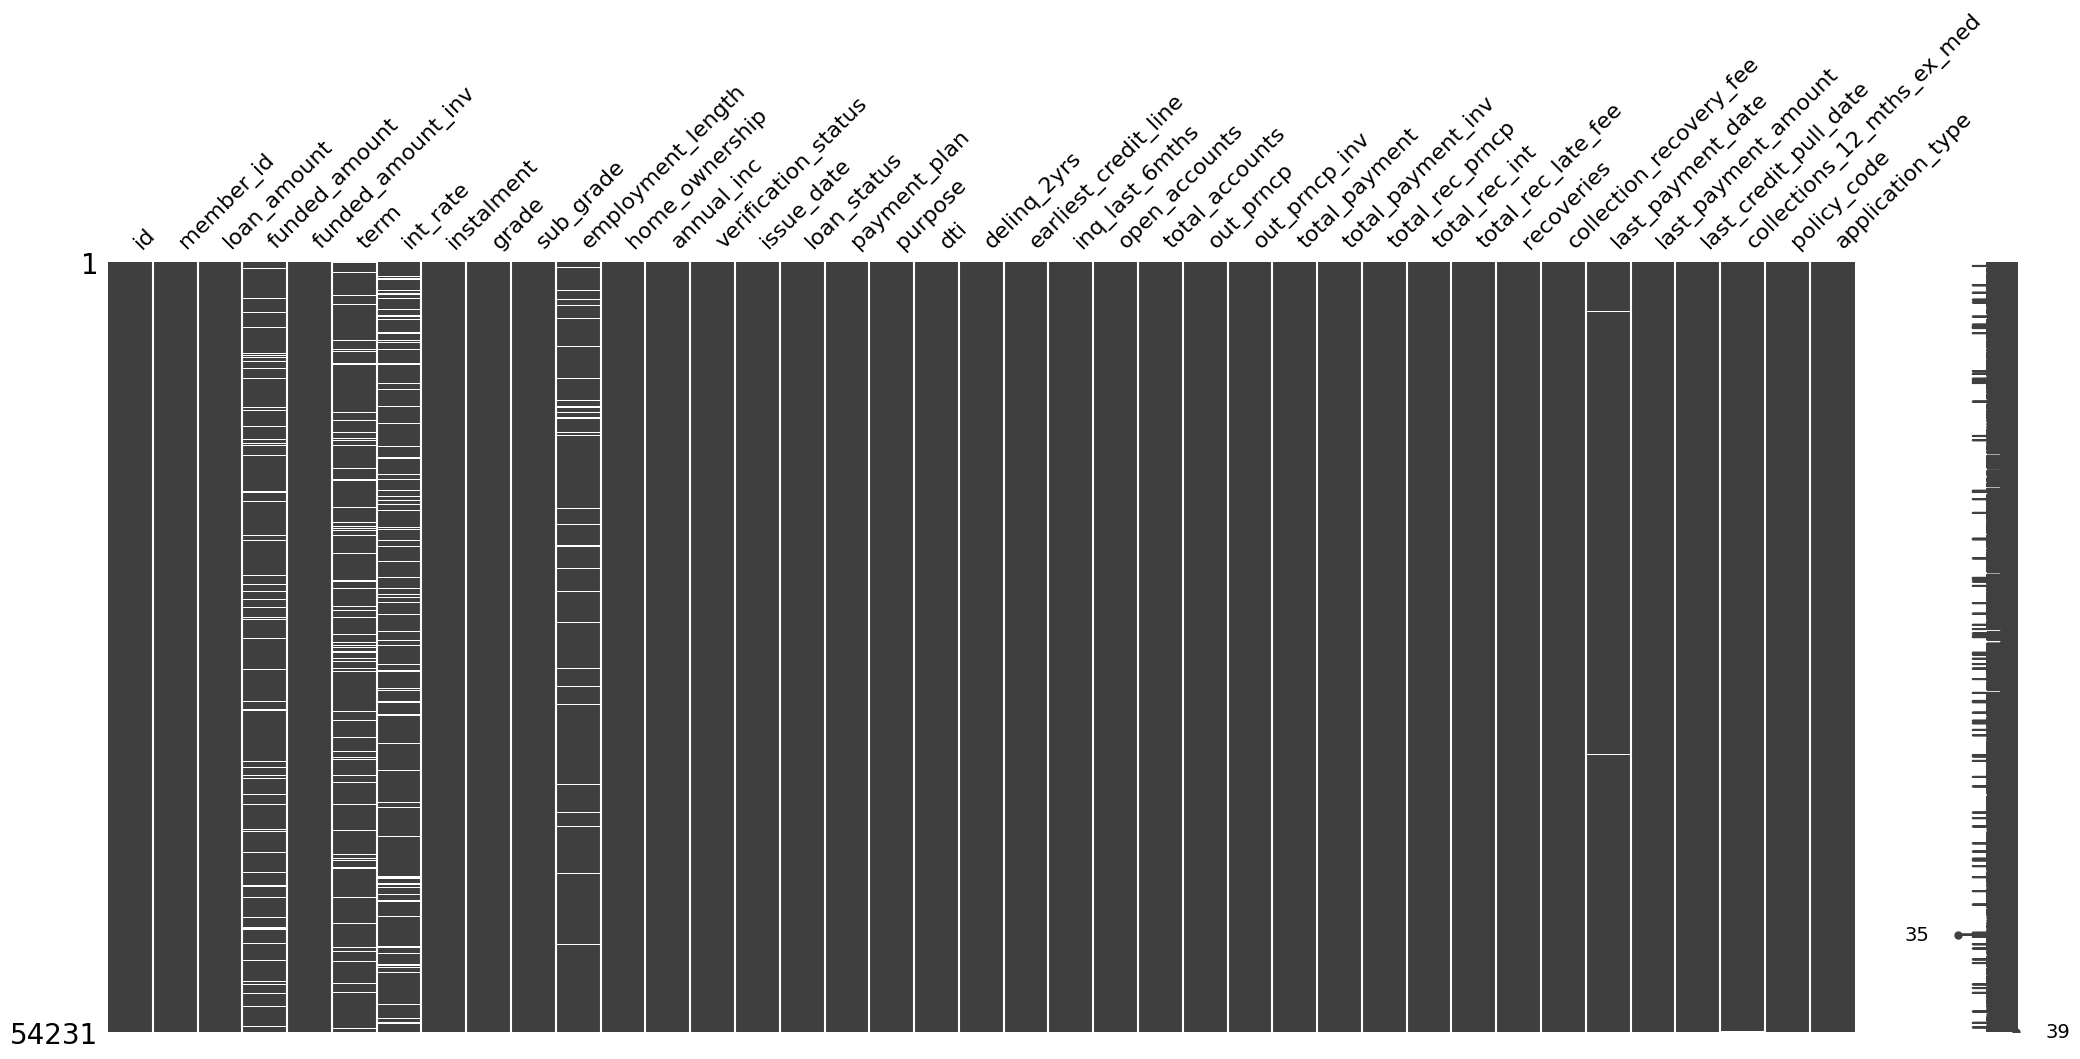

In [7]:
list_columns_with_nulls = ['funded_amount','term','int_rate','employment_length','last_payment_date','last_credit_pull_date','collections_12_mths_ex_med']
plot.Plotter().visualise_null_values(df)

Let's fix the categorical data first:
- `term` categorical data 
- `employment_length` categorical data

And let's explore their distribution:

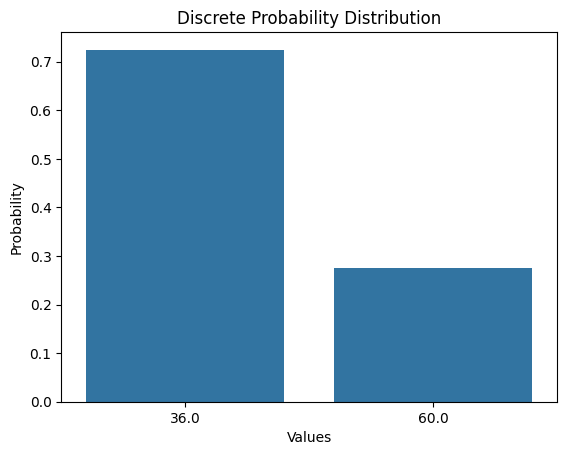

The mode of the distribution is 36.0
The mean of the distribution is 42.60619907398047
The median of the distribution is 36.0


In [8]:
plot.Plotter().discrete_probability_distribution(df,'term') 

print(f"The mode of the distribution is {df['term'].mode()[0]}")
print(f"The mean of the distribution is {df['term'].mean()}")
print(f"The median of the distribution is {df['term'].median()}")

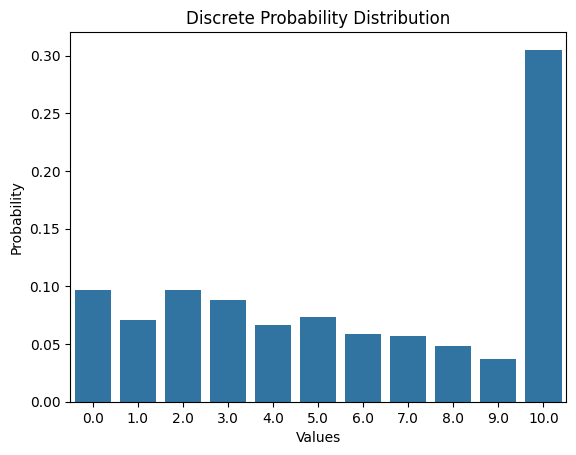

The mode of the distribution is 10.0
The mean of the distribution is 5.690748949398422
The median of the distribution is 6.0


In [9]:
plot.Plotter().discrete_probability_distribution(df,'employment_length') 

print(f"The mode of the distribution is {df['employment_length'].mode()[0]}")
print(f"The mean of the distribution is {df['employment_length'].mean()}")
print(f"The median of the distribution is {df['employment_length'].median()}")

Assuming the nulls are randomly distributed or *Missing Completey At Random (MCAR)*, we could choose to impute them with the mean, median or mode of the distribution. In this case, I am in favour of the mode as it is the default choice for categorical data, and we can see that 36 months is the more prevalent valuue in the `term` data and 10 years is the more prevalent value in the `employment_length` data. I couldn't verify my assumption of MCAR but I will bear this in mind in the analysis below.

Let's impute this data:

In [10]:
df['term'] = df['term'].fillna(36)
df['employment_length'] = df['employment_length'].fillna(10)

Next, let's fix the numerical data:
- `funded_amount` numerical data
- `int_rate` numerical data

And let's have a look to the histograms:

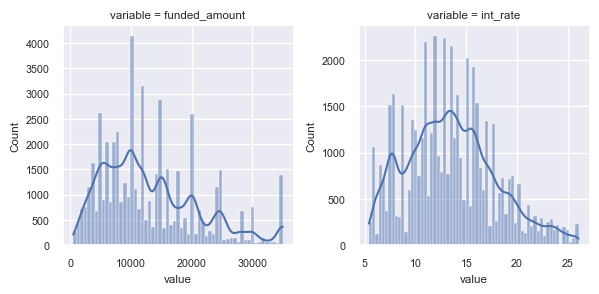

In [11]:
plot.Plotter().seaborn_histograms(df,['funded_amount', 'int_rate'])

We can see that `funded_amount` is slightly skewed to the right, while `int_rate` also looks skewed but only very slightly. In this case, I will propose to use the median to impute the missing data. Here again I making the assumption of MCAR for the null data. `funded_amount` will be closely related to the `loan_amount` but the assumption that null values are missing at random may still be valid.

Using the **data_transforms** module I wrote, I will impute the median to the rows with missing data:

In [12]:
dtr.DataTransform().impute_median_values(df, ['funded_amount', 'int_rate'])

#let's check the data traformations are taking place:
print(df.isnull().sum()/len(df)*100)

id                            0.000000
member_id                     0.000000
loan_amount                   0.000000
funded_amount                 0.000000
funded_amount_inv             0.000000
term                          0.000000
int_rate                      0.000000
instalment                    0.000000
grade                         0.000000
sub_grade                     0.000000
employment_length             0.000000
home_ownership                0.000000
annual_inc                    0.000000
verification_status           0.000000
issue_date                    0.000000
loan_status                   0.000000
payment_plan                  0.000000
purpose                       0.000000
dti                           0.000000
delinq_2yrs                   0.000000
earliest_credit_line          0.000000
inq_last_6mths                0.000000
open_accounts                 0.000000
total_accounts                0.000000
out_prncp                     0.000000
out_prncp_inv            

Lastly, let's remove the empty rows of:
- `last_payment_date` date data
- `last_credit_pull_date` date data
- `collections_12_mths_ex_med` numerical data

In [13]:
df = df.dropna(axis=0)

Final checks. Let's count nulls and visualise the data to make sure everything looks fine:


id                            0.0
member_id                     0.0
loan_amount                   0.0
funded_amount                 0.0
funded_amount_inv             0.0
term                          0.0
int_rate                      0.0
instalment                    0.0
grade                         0.0
sub_grade                     0.0
employment_length             0.0
home_ownership                0.0
annual_inc                    0.0
verification_status           0.0
issue_date                    0.0
loan_status                   0.0
payment_plan                  0.0
purpose                       0.0
dti                           0.0
delinq_2yrs                   0.0
earliest_credit_line          0.0
inq_last_6mths                0.0
open_accounts                 0.0
total_accounts                0.0
out_prncp                     0.0
out_prncp_inv                 0.0
total_payment                 0.0
total_payment_inv             0.0
total_rec_prncp               0.0
total_rec_int 

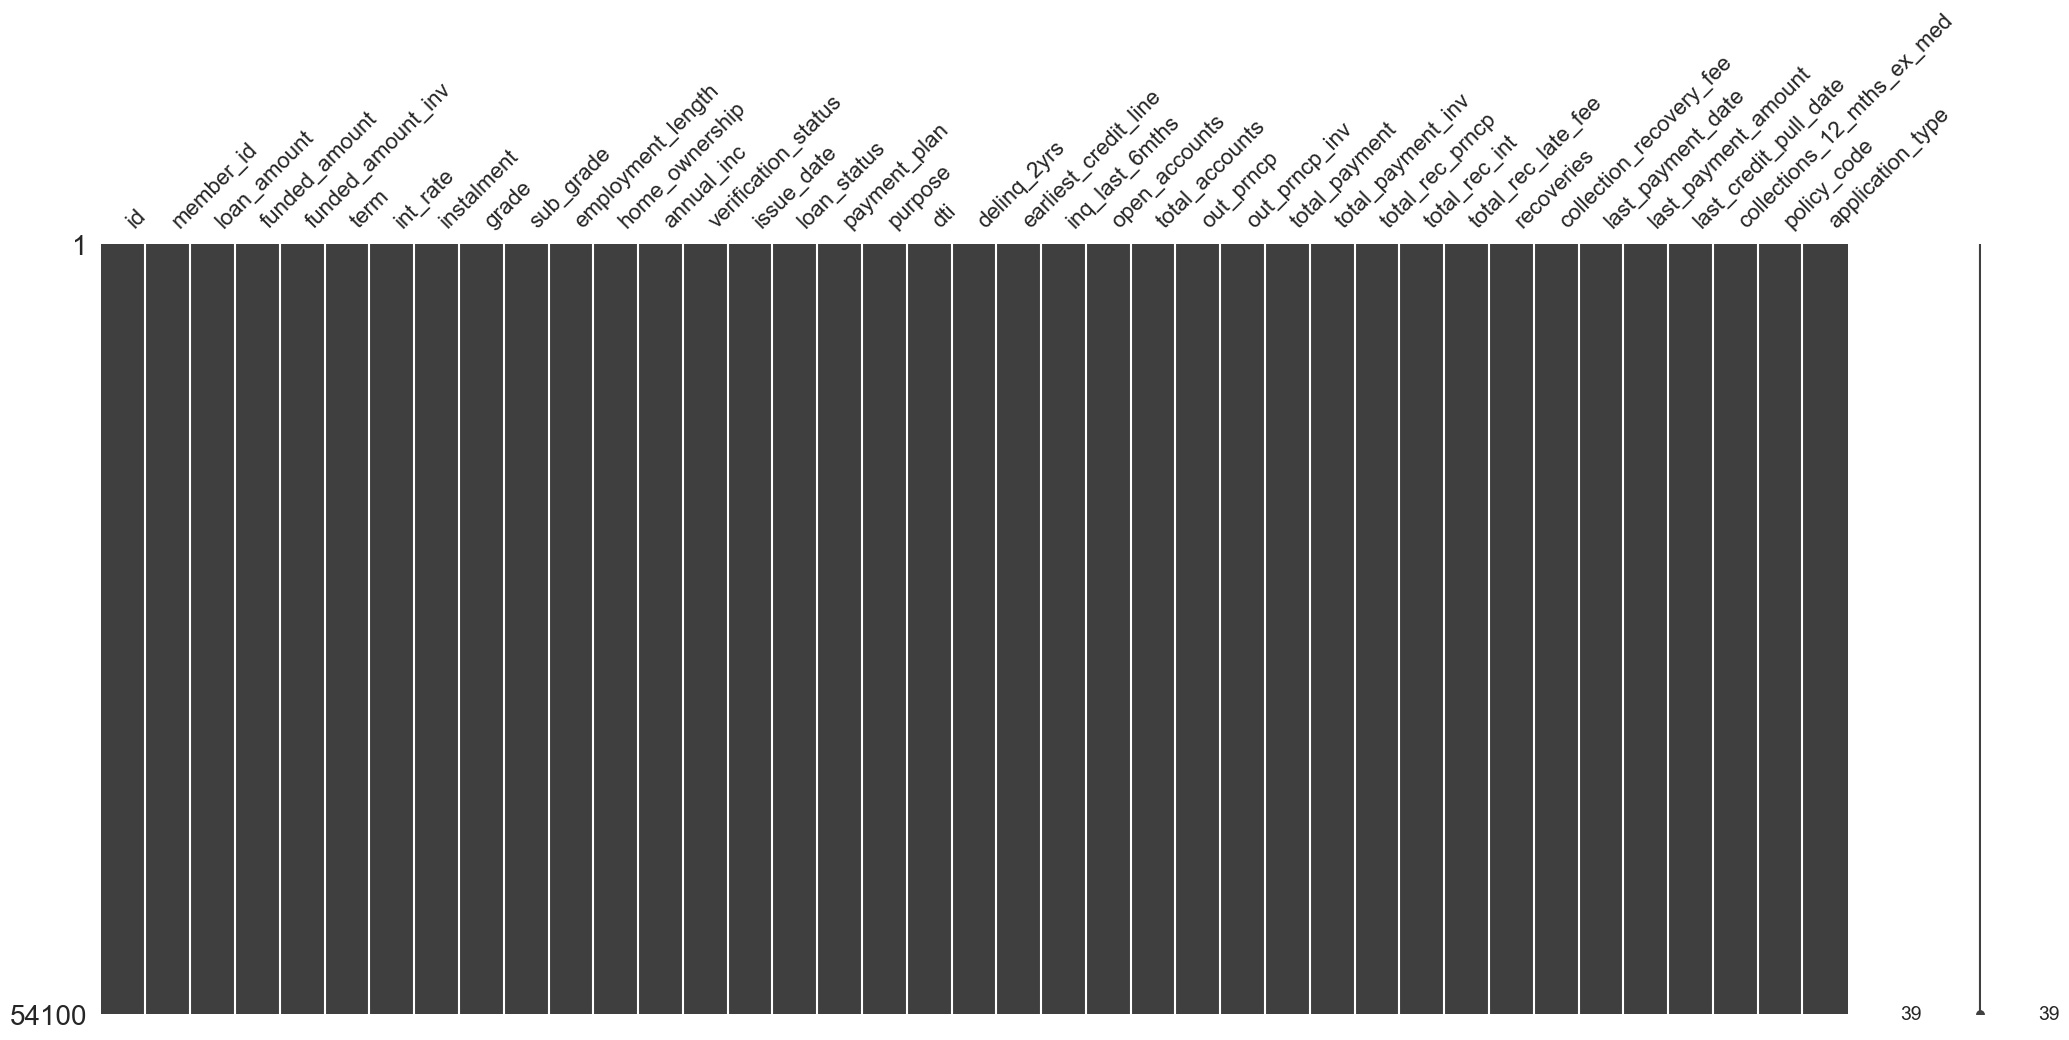

In [14]:
print(df.isnull().sum()/len(df)*100)
plot.Plotter().visualise_null_values(df)

In [15]:
# Let's save a copy of the dataframe:
df_base = df

## 2. Identifiying and correcting skewness

To correct skewness, first I want to identify the columns that contain numeric data. To do this I have implemented the function below to obtain a list of columns from the df with numeric features.


In [16]:
# NOTE could also use df.select_dtypes to select just numerical columns as well. 
def get_list_with_numeric_features(df):
    numeric_features = []
    for column in df:
        if df[column].dtype == 'float64' or df[column].dtype == 'int64' or df[column].dtype == 'Int64':
            numeric_features.append(column)
    numeric_features.remove("term")
    numeric_features.remove("employment_length")

    categorical_features = [col for col in df.columns if col not in numeric_features]
    numeric_features.remove("id")
    numeric_features.remove("member_id") 
    numeric_features.remove("collections_12_mths_ex_med")
    numeric_features.remove("policy_code")

    return numeric_features, categorical_features

So, using the function above and applying it to the dataframe, I can obtain the following lists:

In [17]:
numeric_features, categorical_features = get_list_with_numeric_features(df)
print(f'List of columns with numeric features: {numeric_features}')
print('\n')
print(f'List of columns with categorical features: {categorical_features}')


List of columns with numeric features: ['loan_amount', 'funded_amount', 'funded_amount_inv', 'int_rate', 'instalment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_accounts', 'total_accounts', 'out_prncp', 'out_prncp_inv', 'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_payment_amount']


List of columns with categorical features: ['term', 'grade', 'sub_grade', 'employment_length', 'home_ownership', 'verification_status', 'issue_date', 'loan_status', 'payment_plan', 'purpose', 'earliest_credit_line', 'last_payment_date', 'last_credit_pull_date', 'application_type']


Once I have done this, I can have a look to the histograms for the numeric data:

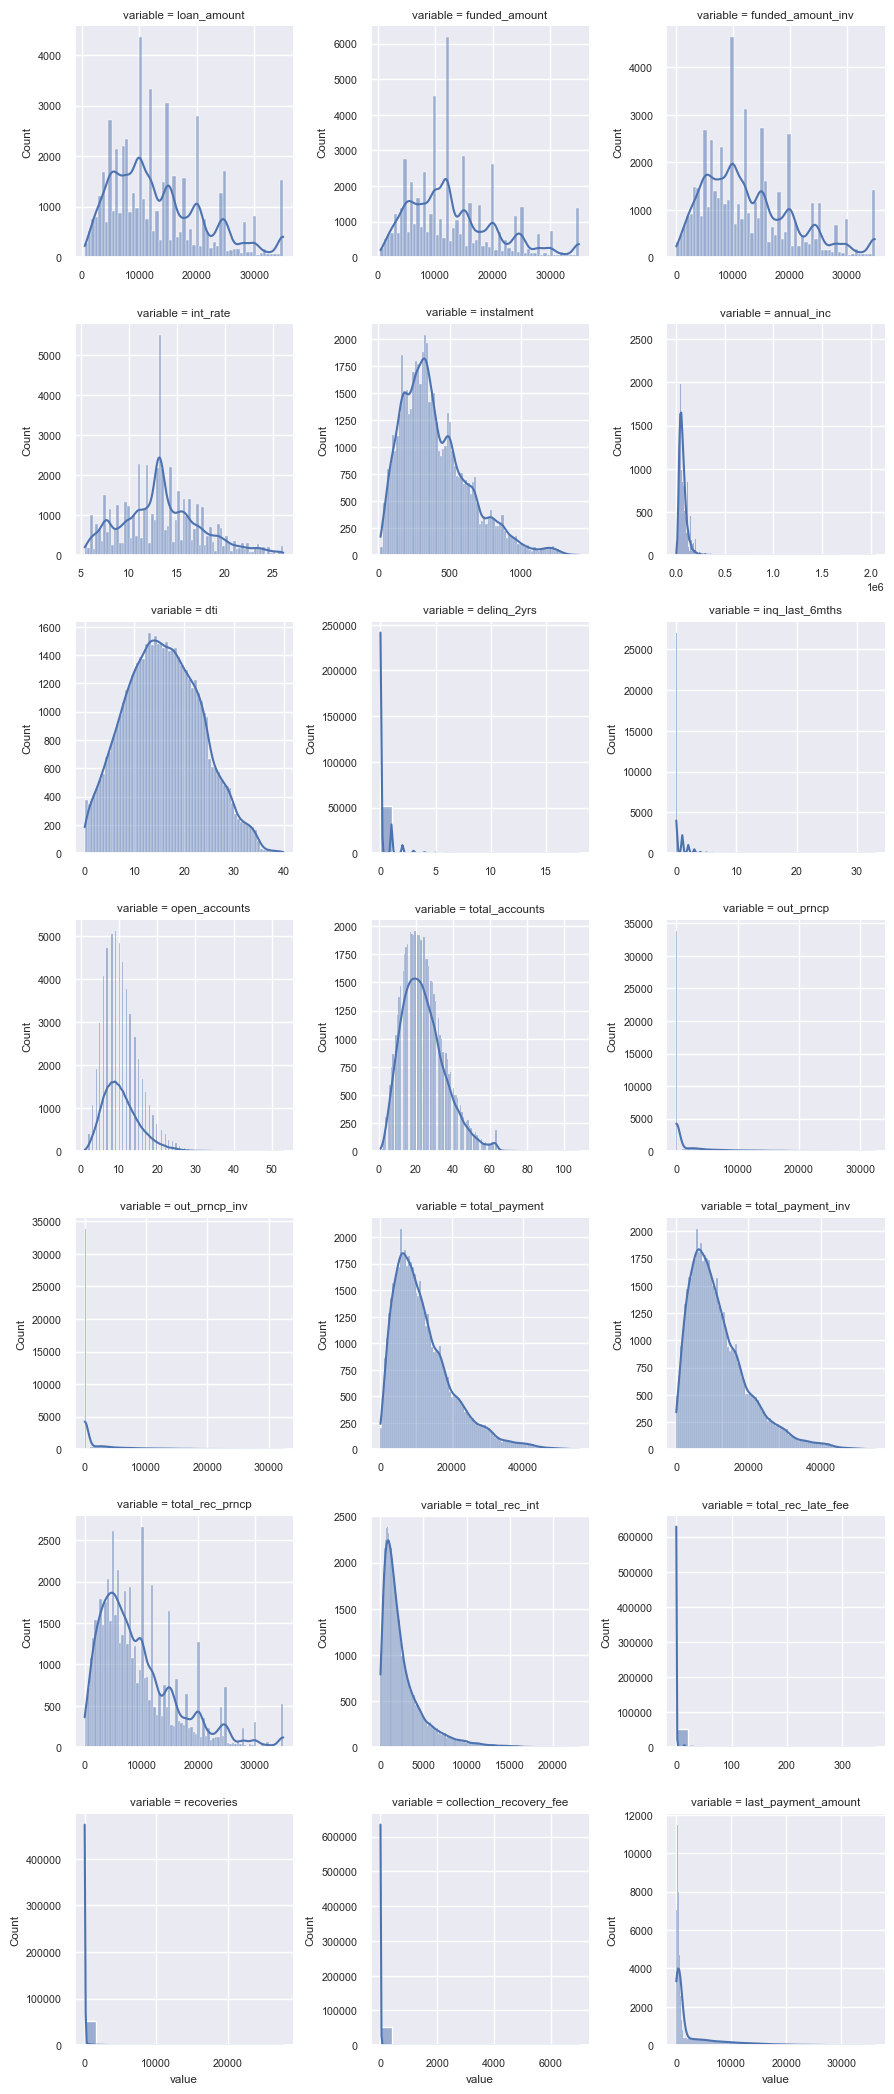

In [18]:
plot.Plotter().seaborn_histograms(df, numeric_features)

A few noteworthy matters arise from the `Facetgrid `plot:
- `loan_amount`, `funded_amount`,  `funded_amount_inv` and `total_rec_prncp` look strongly autocorrelated. We should make a note of this to check for collinearity later.
- `total_payment` and `total_payment_inv` look strongly autocorrelated. We should make a note of this to check for collinearity later.
- The aforementioned variables appear to be somewhat right-skewed as well, with a long tail of high values
- `instalment` and `total_rec_int` also appear to be right-skewed.
- Other variables look either normally distributed, or do not present a good variance or distribution, which would be hard to correct.

Let's calculate the skew values on the columns we suspect data may be skewed. To do this I will be using the function get_skewness I implemented in my module **DataFrameTransform**:

Population loan_amount has a skew value of 0.8
Population funded_amount has a skew value of 0.87
Population funded_amount_inv has a skew value of 0.81
Population total_rec_prncp has a skew value of 1.26
Population total_payment has a skew value of 1.27
Population total_payment_inv has a skew value of 1.26
Population instalment has a skew value of 1.0
Population total_rec_int has a skew value of 2.2


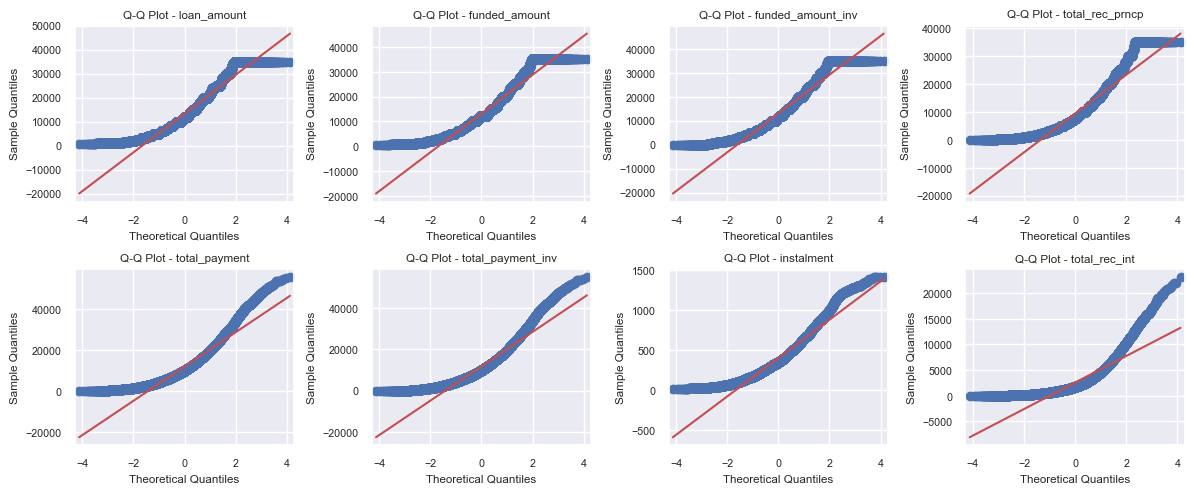

In [19]:
list_skewed_columns = ['loan_amount', 'funded_amount', 'funded_amount_inv', 'total_rec_prncp', 'total_payment', 'total_payment_inv', 'instalment', 'total_rec_int']

dfr.DataFrameTransform().get_skewness(df, list_skewed_columns)

# Visualise the data to analyse the skew using quantile-quantile plots:
plot.Plotter().qq_plots(df, list_skewed_columns)

We know that:
- If the skewness is between -0.5 and 0.5, the data are fairly symmetrical

- If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed

- If the skewness is less than -1 or greater than 1, the data are highly skewed

And, as the skew values are positive this corroborates our suspicion on right skewness (in other words, the tail of the distribution is longer towards the right hand side of the curve). Normalised data also would follow a diagonal line in the q-q graph, so the above indicates and confirms skewness in the data.

To correct the skewness I will test a couple of options:
1. Using the Yeo-Johnson transform, and saving the tranformed data in dataframe `df_1`
2. Using the natural log function, and saving the tranformed data in dataframe `df_2`

I will then compare which transformation improves the skewness the best.

Population loan_amount has a skew value of -0.04
Population funded_amount has a skew value of -0.03
Population funded_amount_inv has a skew value of -0.04
Population total_rec_prncp has a skew value of -0.02
Population total_payment has a skew value of -0.01
Population total_payment_inv has a skew value of 0.01
Population instalment has a skew value of -0.02
Population total_rec_int has a skew value of 0.0


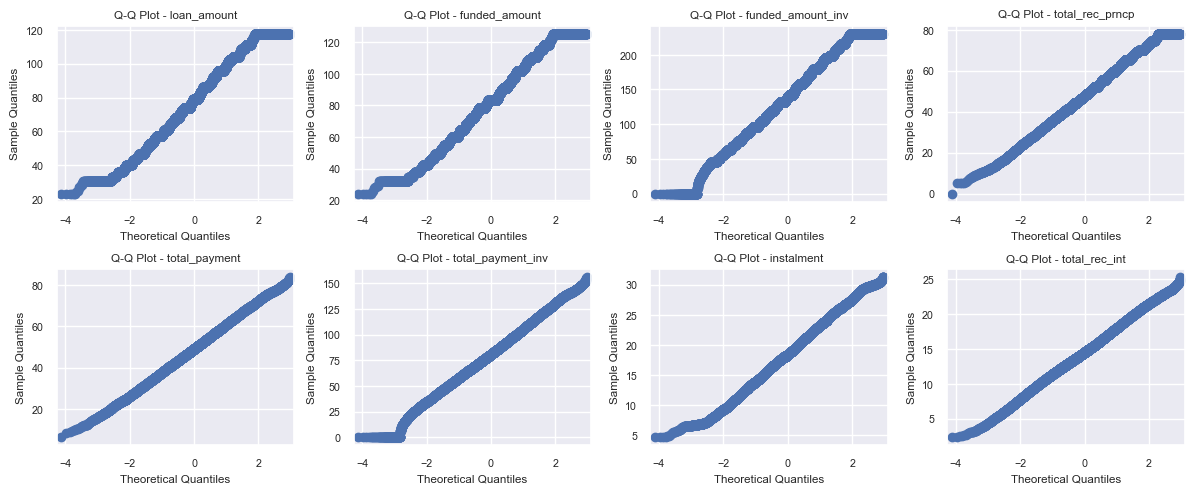

In [20]:
df_1 = dtr.DataTransform().yeojohnson_transform(df, list_skewed_columns)

dfr.DataFrameTransform().get_skewness(df_1, list_skewed_columns)

plot.Plotter().qq_plots(df_1, list_skewed_columns)

Population loan_amount has a skew value of -4.35
Population funded_amount has a skew value of -4.58
Population funded_amount_inv has a skew value of -5.06
Population total_rec_prncp has a skew value of -3.11
Population total_payment has a skew value of -3.86
Population total_payment_inv has a skew value of -4.61
Population instalment has a skew value of -2.05
Population total_rec_int has a skew value of -2.11


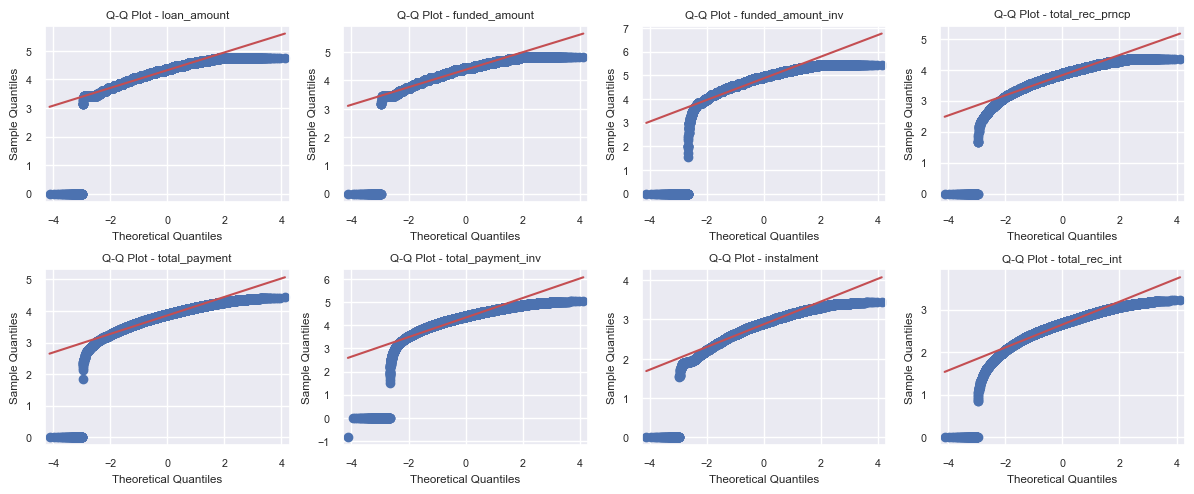

In [21]:
df_2 = dtr.DataTransform().log_transform(df, list_skewed_columns)

dfr.DataFrameTransform().get_skewness(df_2, list_skewed_columns)

plot.Plotter().qq_plots(df_2, list_skewed_columns)

The Yeo-Johnson transform in the dataframe `df_1` seems to correct skewness better than the log transform so I will write the tranformed data back to `df`. Let's visualise the histograms after the transformation, as they should show a more symmetrical distribution:

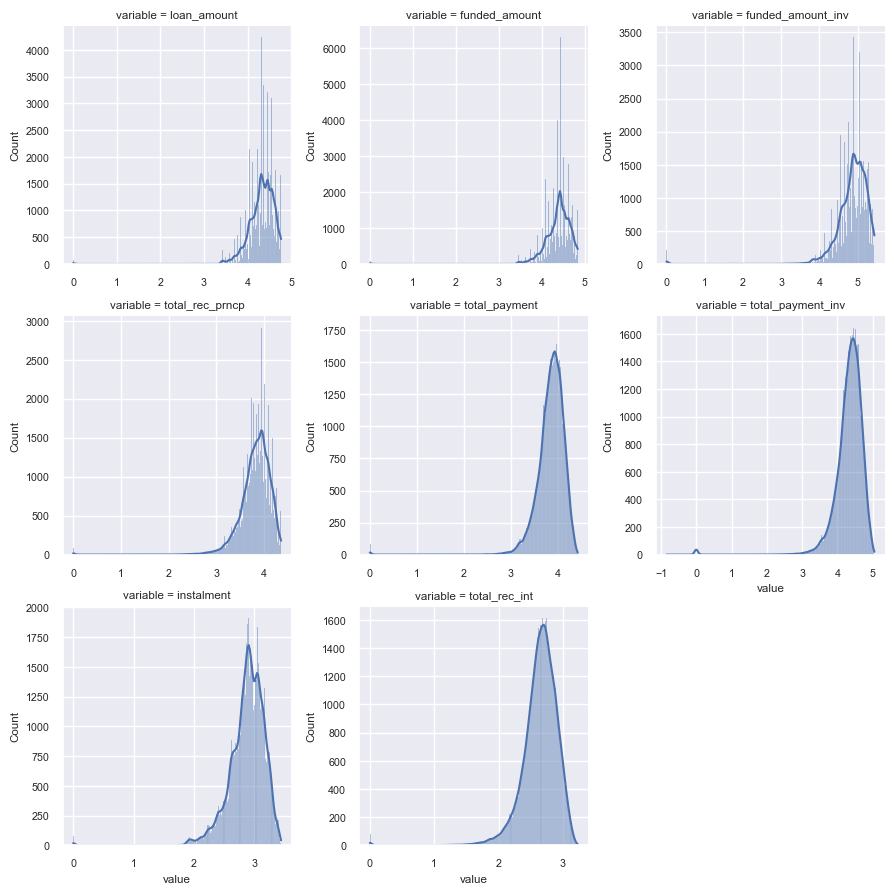

In [22]:
# Use the corrected data stored in df_1:
df = df_1 

plot.Plotter().seaborn_histograms(df, list_skewed_columns)

Below I checked skewness on categorical variables but this may be difficult to correct. We know that `term` and `employment_length` may present some skewness (as can be seen in the count plots above in Section 1). 

c:\Users\DanielValero\miniconda3\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


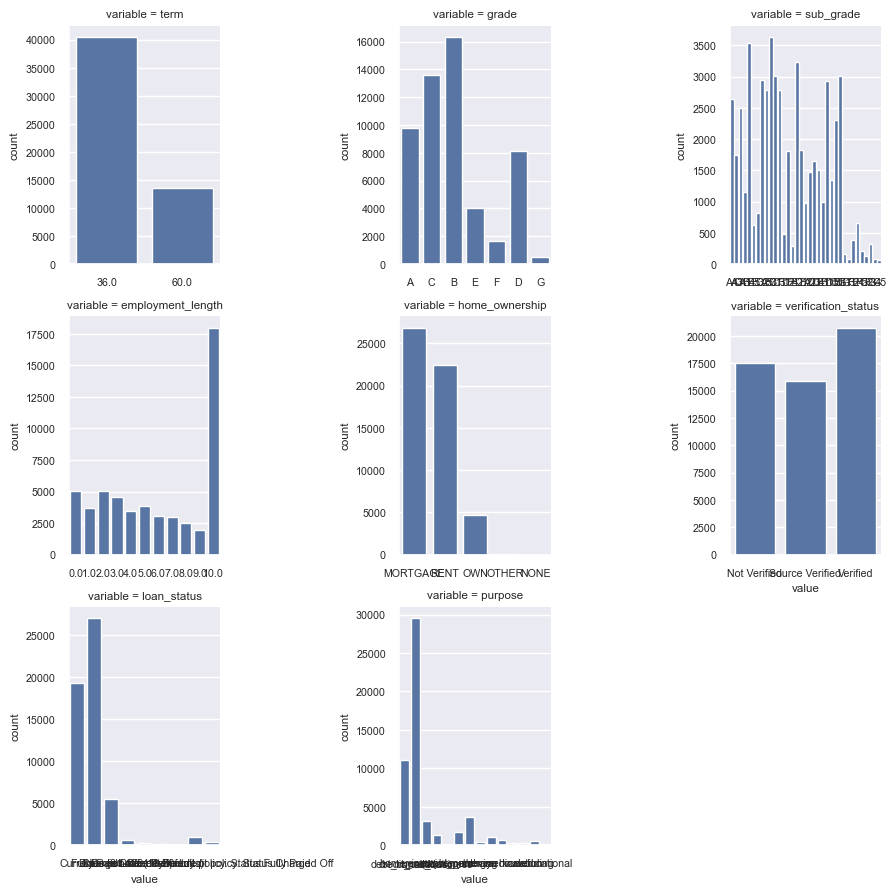

In [23]:
categorical_features = ['term', 'grade', 'sub_grade', 'employment_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose']

plot.Plotter().count_plots(df, categorical_features) 

Let's look at some more graphs in more detail, as they could be of use later in the analysis:

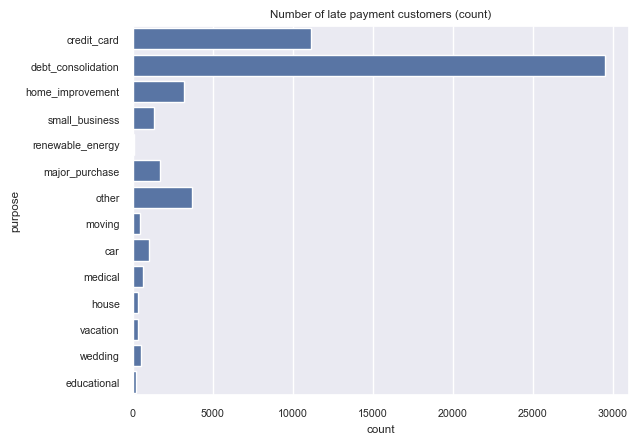

In [24]:
plot.Plotter().count_plot_single(df['purpose'], 'Number of late payment customers (count)') 

## 3. Removing outliers from the data

To identify outliers from the data, I believe the best tool to use are box-and-whisker graphs. To visualise box-and-whisker plots I will use the function I immplemented in my **plot** module:

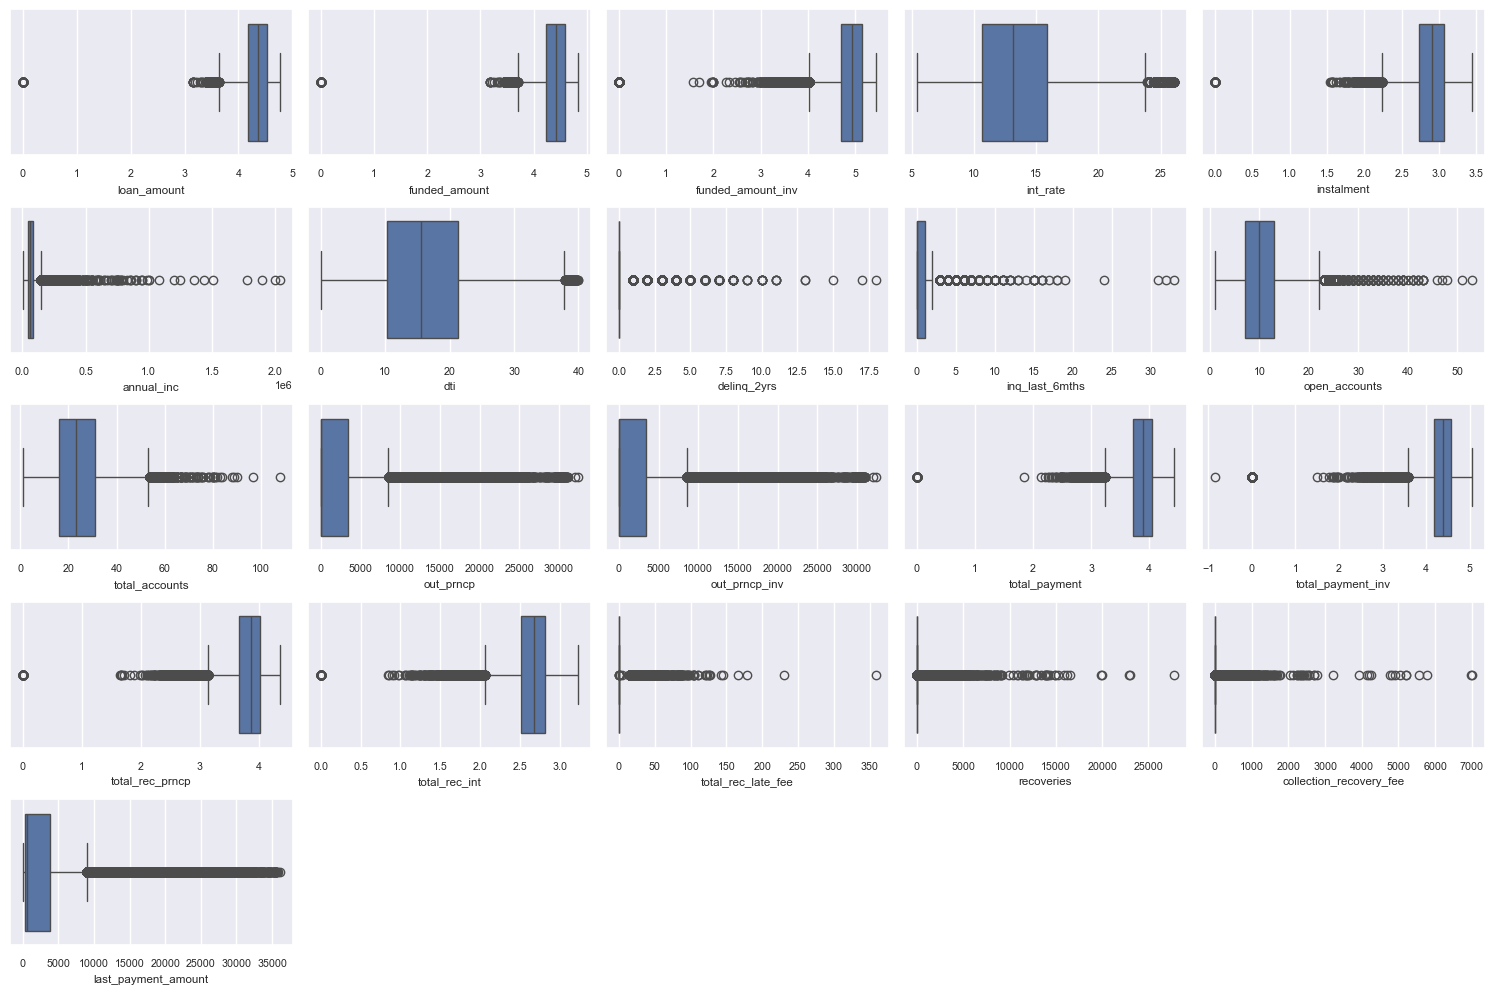

In [25]:
plot.Plotter().box_whisker_plots(df, numeric_features)

The data shows extreme values in most cases (values that are over 1.5 times the inter-quantile range, or IQR). However, in most cases this is data that does not present anomalies (for example, for the `int_rate` we could have extreme values that are perfectly feasible). 
The only graphs that present 'strange' outliers are the values around 0 for:
> 'loan_amount', 'funded_amount', 'funded_amount_inv', 'instalment', 'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int'

Let's look at `loan_amount`, for example, in more detail:

In [26]:
plot.Plotter().box_whisker_single(df,'loan_amount')

#Let's count how many 0's we have. I have chosen funded_amount_inv as it has the largest number of zeros:
zero_count = (df['funded_amount_inv'] == 0).sum()
print(zero_count)

209


To remove these outlier values I will use a method I implemented in my **data_transforms** module:

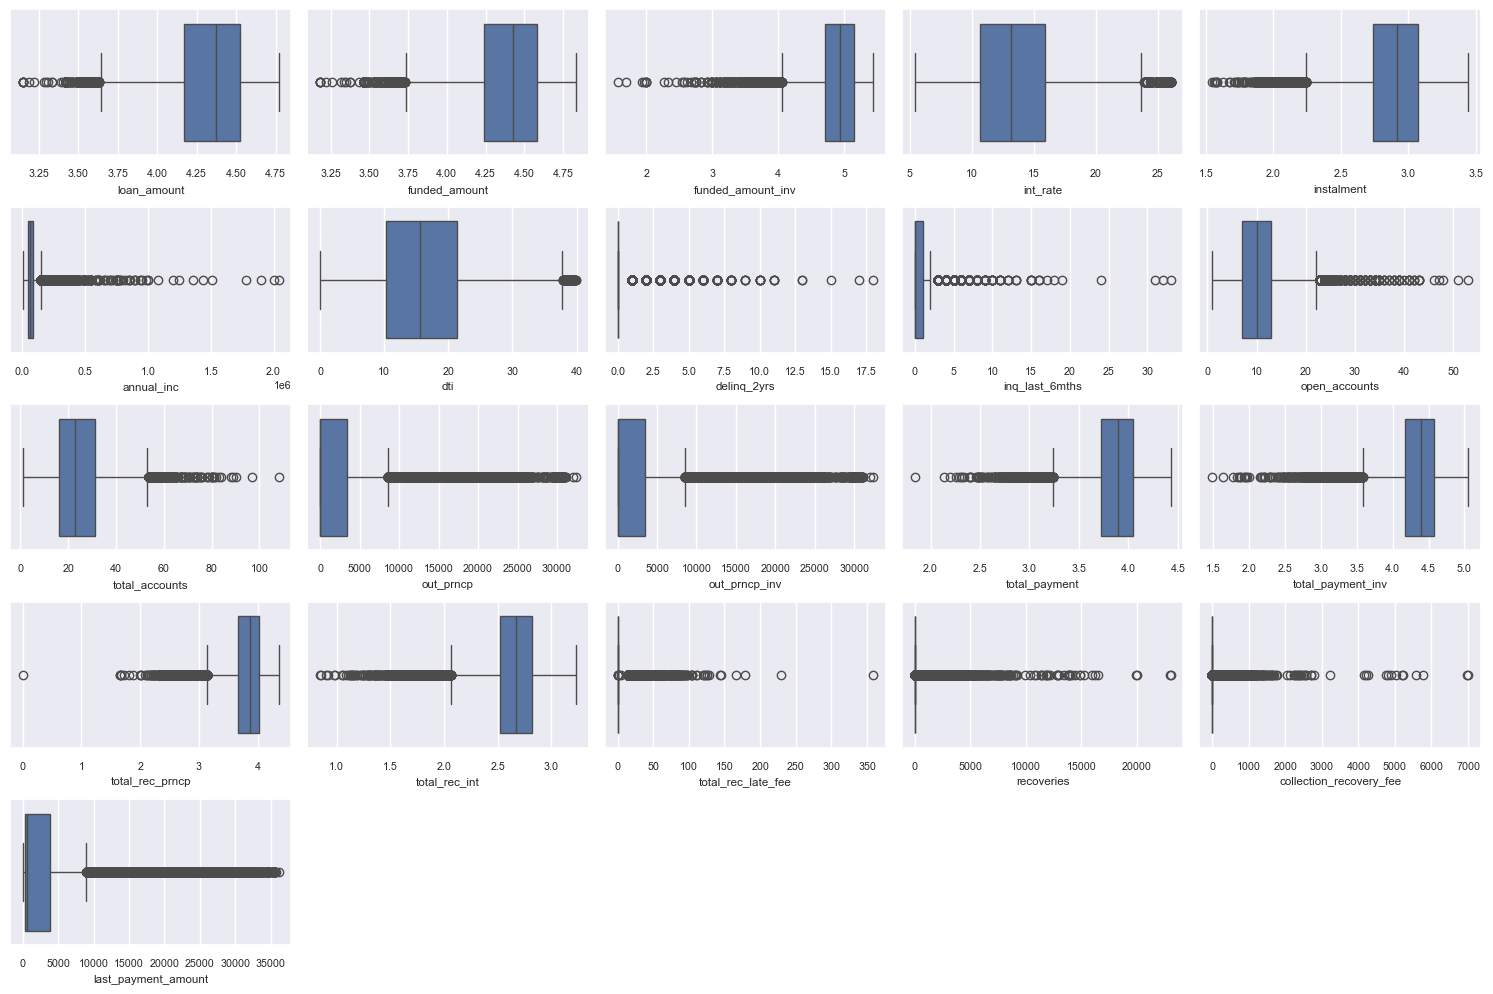

In [27]:
list_outliers_columns = ['loan_amount', 'funded_amount', 'funded_amount_inv', 'instalment', 'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int']

#for each_column in list_outliers_columns:
#    df = dtr.DataTransform().remove_n_smallest(df, each_column, 16)
df = dtr.DataTransform().remove_n_smallest(df, 'funded_amount_inv', 209)

#Check that outliers have been removed:
plot.Plotter().box_whisker_plots(df, numeric_features)

`total_rec_prncp` still presents some outliers. Let's check how many and remove them:

In [28]:
zero_count = (df['total_rec_prncp'] == 0).sum()
print(zero_count)

1


In [29]:
df = dtr.DataTransform().remove_n_smallest(df, 'total_rec_prncp', 1)
plot.Plotter().box_whisker_single(df,'total_rec_prncp')

## 4. Dropping overly correlated columns

__Collinearity__ is a term that describes a high degree of correlation between two independent (exogenous) variables. Because collinearity occurs over the *linear relationship* between variables, a *correlation heatmap* is a great way to get us started on identifying which variables are highly related. Correlation heatmaps display a matrix of correlation coefficients between pairs of variables in a dataset, with the colour of each element in the matrix representing the degree of correlation between a pair of variables:

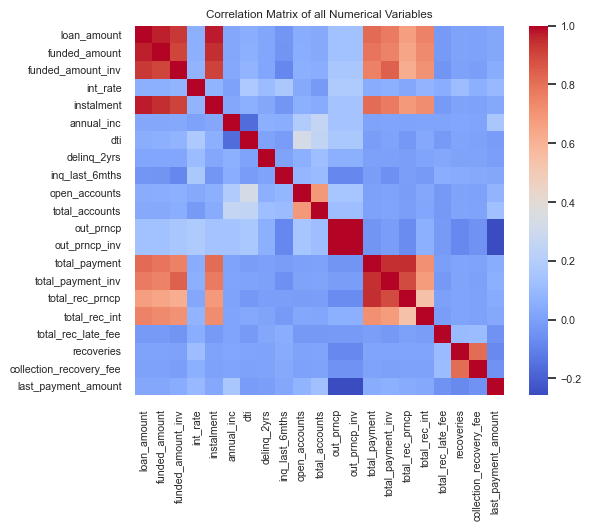

In [30]:
# First select the numeric columns of the dataframe: df[numeric_features]
plot.Plotter().correlation_plot(df[numeric_features])

Looks like we have some heavy correlation in the heatmap, and potentially **multicollinearity**. 

Variation Inflation Factor **VIF** is another method for identifying collinearity that we could use. But in our case, as we will only to use our model for predictive purposes, then keeping the collinear terms in is completely valid.

## 5. Current State of the loans

Now that I have a clean set of data, I want to analyse the current state of the loans. But since I transformed the data using the Yeo_Johnson transformation to reduce skewness, I want to revert back to the dataframe `df_base` to perform calculations.

In [67]:
df = df_base

One of the figures we may want to be aware of is the percentage of the loans that are recovered against the investor funding.
In other words, the number of loans that have £0 remaining outstanding:

In [68]:
percentage_loans_recoverd_inv = len(df[df['out_prncp_inv']==0]) / len(df) *100
print(f'The percentage of loans recovered is: {round(percentage_loans_recoverd_inv,2)} %')

The percentage of loans recovered is: 62.54 %


Another figure we may be interested in is the percentage of the loans that will be paid back 6 months' in the future.
If we substract 6 months of payments (including interest) to the outstanding amount, then any value below £0 would mean the loan has been paid.

In [69]:
df['out_prncp_in_six_months'] = df['out_prncp'] - df['instalment']*6 
percentage_loans_recoverd_in_six_m = len(df[df['out_prncp_in_six_months']<=0]) / len(df) *100
print(f'Estimated percentage of loans that will be recovered in 6 monhts: {round(percentage_loans_recoverd_in_six_m,2)} %')

Estimated percentage of loans that will be recovered in 6 monhts: 62.55 %


### 5.1 Calculating loss

Let's imagine the CEO wants to check what percentage of loans have been a loss to the company. 
Loans marked as Charged Off in the loan_status column represent a loss to the company.

In [70]:
percentage_loans_charged_off = len(df[df['loan_status']=='Charged Off']) / len(df) *100
print(f'The percentage of loans that have been a loss is: {round(percentage_loans_charged_off,2)} %')

The percentage of loans that have been a loss is: 10.17 %


Let's now calculate the percentage of charged off loans historically and amount that was paid towards these loans before being charged off.

In [71]:
mask = df['loan_status']=='Charged Off'
total_paymnt_before_charged_off = df['total_payment'][mask].sum() 
print(f'Total paid towards loans before being charged off: £' + '{:10,.2f}'.format(total_paymnt_before_charged_off))

Total paid towards loans before being charged off: £ 21,259.06


### 5.2 Calculating the projected loss

Based on the interest rate of the loan and the loans term, you can calculate how much revenue the loan would have generated for the company.

In [72]:
df['theoretical_revenue'] = df['instalment']*df['term'] - df['total_payment']
theoretical_revenue = df['theoretical_revenue'][mask].sum()

mask = df['loan_status']!='Charged Off' #filter rows that are not the charged off ones to calculate actual revenue
percentage_revenue_lost = theoretical_revenue / df['theoretical_revenue'][mask].sum() * 100

print(f'Revenue that the charged off loans would have generated for the company: £' + '{:10,.2f}'.format(theoretical_revenue))
print(f'Estimated percentage of revenue lost: {round(percentage_revenue_lost,2)} %')

Revenue that the charged off loans would have generated for the company: £682,801.00
Estimated percentage of revenue lost: 12.06 %


### 5.3 Calculating possible loss

There are customers who are currently behind with their loan payments this subset of customers represent a risk to company revenue. 
Percentage of users in this bracket that currently represent as a percentage of all loans:

In [73]:
percentage_loans_late = (len(df[df['loan_status']=='Late (31-120 days)']) + len(df[df['loan_status']=='Late (16-30 days)'])) / len(df) *100
print(f'The percentage of loans at risk of loss is: {round(percentage_loans_late,2)} %')

The percentage of loans at risk of loss is: 1.27 %


Projected loss of these loans if the customer were to finish the loans term:

In [74]:
theoretical_loss = df['theoretical_revenue'][df['loan_status']=='Late (31-120 days)'].sum() + df['theoretical_revenue'][df['loan_status']=='Late (16-30 days)'].sum()
print(f'Projected loss if the late payment customers were to finish the loans term: £' + '{:10,.2f}'.format(theoretical_loss))

Projected loss if the late payment customers were to finish the loans term: £ 87,344.09


If customers converted to Charged Off, the percentage of total revenue that these customers and the customers who have already defaulted on their loan is:

In [75]:
percentage_potential_loss = theoretical_loss / df['theoretical_revenue'][mask].sum() * 100
print(f'Estimated percentage of revenue lost if late customers converted to Charged Off: {round(percentage_revenue_lost + percentage_potential_loss,2)} %')

Estimated percentage of revenue lost if late customers converted to Charged Off: 13.6 %


### 5.4 Indicators of loss 

In this section I will be analysing the data to visualise the possible indicators that a customer will not be able to pay the loan. 
To help identify which columns will be of interest, I will create a subset of users who have already stopped paying and customers who are currently behind on payments and plot another correlation matrix to work out which columns are of interest. 

In [92]:
df_loss = df.loc[(df['loan_status'] == 'Late (16-30 days)') | (df['loan_status'] == 'Late (31-120 days)')]

df_loss.head()


id  member_id  loan_amount  funded_amount  funded_amount_inv  term  \
17   38655869   41439673     4.539230       4.599277           5.162785  60.0   
140  38644147   41427862     4.469418       4.528056           5.078396  36.0   
168  38635317   41419102     4.111874       4.163440           4.647587  36.0   
171  38635273   41419056     4.454829       4.513173           5.060771  36.0   
243  38625326   41409103     4.043075       4.093311           4.564989  36.0   

     int_rate  instalment grade sub_grade  employment_length home_ownership  \
17      13.66    2.998496     C        C3               10.0       MORTGAGE   
140     14.99    3.082338     C        C5                7.0           RENT   
168      8.67    2.671533     B        B1               10.0       MORTGAGE   
171     13.16    3.029697     A        A5                5.0           RENT   
243     11.44    2.613854     B        B4                9.0       MORTGAGE   

     annual_inc verification_status issue_date         loan_status  \
17      52000.0            Verified 2021-01-01  Late (31-120 days)   
140    102000.0            Verified 2021-01-01  Late (31-120 days)   
168    106000.0        Not Verified 2021-01-01  Late (31-120 days)   
171     70000.0     Source Verified 2021-01-01  Late (31-120 days)   
243     35000.0        Not Verified 2021-01-01   Late (16-30 days)   

    payment_plan             purpose    dti  delinq_2yrs earliest_credit_line  \
17             n  debt_consolidation   8.98            2           1994-10-01   
140            n  debt_consolidation  25.91            0           1991-07-01   
168            n  debt_consolidation  15.07            0           1998-05-01   
171            n  debt_consolidation  11.25            3           1994-04-01   
243            n  debt_consolidation  30.18            0           2000-09-01   

     inq_last_6mths  open_accounts  total_accounts  out_prncp  out_prncp_inv  \
17                6             11              15   16748.37       16748.37   
140               3             17              39   11940.58       11940.58   
168               0              8              42    4487.25        4487.25   
171               1             13              21   11976.55       11976.55   
243               0             11              23    3649.02        3649.02   

     total_payment  total_payment_inv  total_rec_prncp  total_rec_int  \
17        3.584590           4.028285         3.429536       2.684052   
140       3.691096           4.156604         3.620564       2.674596   
168       3.350651           3.747928         3.321238       2.302708   
171       3.574384           4.016011         3.556544       2.471793   
243       3.332887           3.726727         3.282288       2.350900   

     total_rec_late_fee  recoveries  collection_recovery_fee  \
17                  0.0         0.0                      0.0   
140                 0.0         0.0                      0.0   
168                15.0         0.0                      0.0   
171                 0.0         0.0                      0.0   
243                 0.0         0.0                      0.0   

    last_payment_date  last_payment_amount last_credit_pull_date  \
17         2021-10-01               434.72            2022-01-01   
140        2021-11-01               540.71            2022-01-01   
168        2021-11-01               394.76            2022-01-01   
171        2021-09-01               471.37            2021-09-01   
243        2021-12-01               164.74            2022-01-01   

     collections_12_mths_ex_med  policy_code application_type  \
17                          0.0            1       INDIVIDUAL   
140                         0.0            1       INDIVIDUAL   
168                         0.0            1       INDIVIDUAL   
171                         0.0            1       INDIVIDUAL   
243                         0.0            1       INDIVIDUAL   

     out_prncp_in_six_months  theore

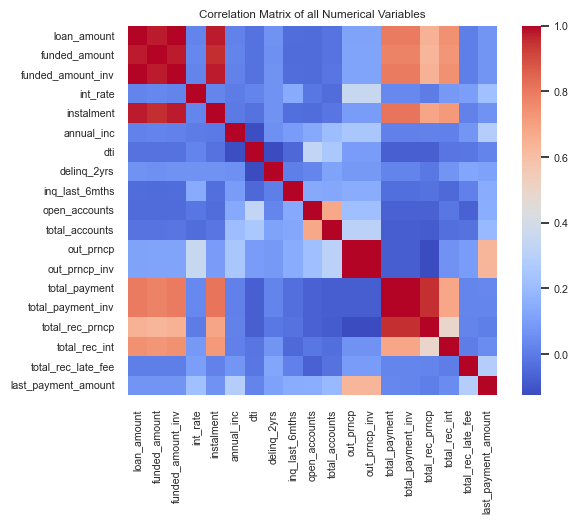

In [93]:

numeric_features_loss = ['loan_amount', 'funded_amount', 'funded_amount_inv', 'int_rate', 'instalment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_accounts', 'total_accounts', 'out_prncp', 'out_prncp_inv', 'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'last_payment_amount']

plot.Plotter().correlation_plot(df_loss[numeric_features_loss])


Comparing this correlation heatmap with the one for the whole dataset:

> 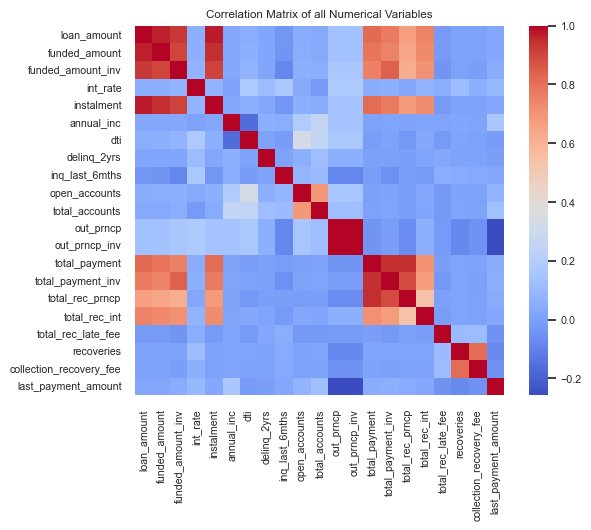

We can see that `last_payment_amount` is now somewhat correlated to `out_prncp`. In other words, the outstanding amount is correlated to the last payment amount. Intituively, we can see that this is not an useful indicator of loss or when a customer is not paying. From all the variables I think `delinq_2yr` is the one that could have been a good indicator but unfortunately it is not correlated to any other numerical variable.

Let's now investigate the categorical variables using count plots:

c:\Users\DanielValero\miniconda3\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning:

Using the countplot function without specifying `order` is likely to produce an incorrect plot.



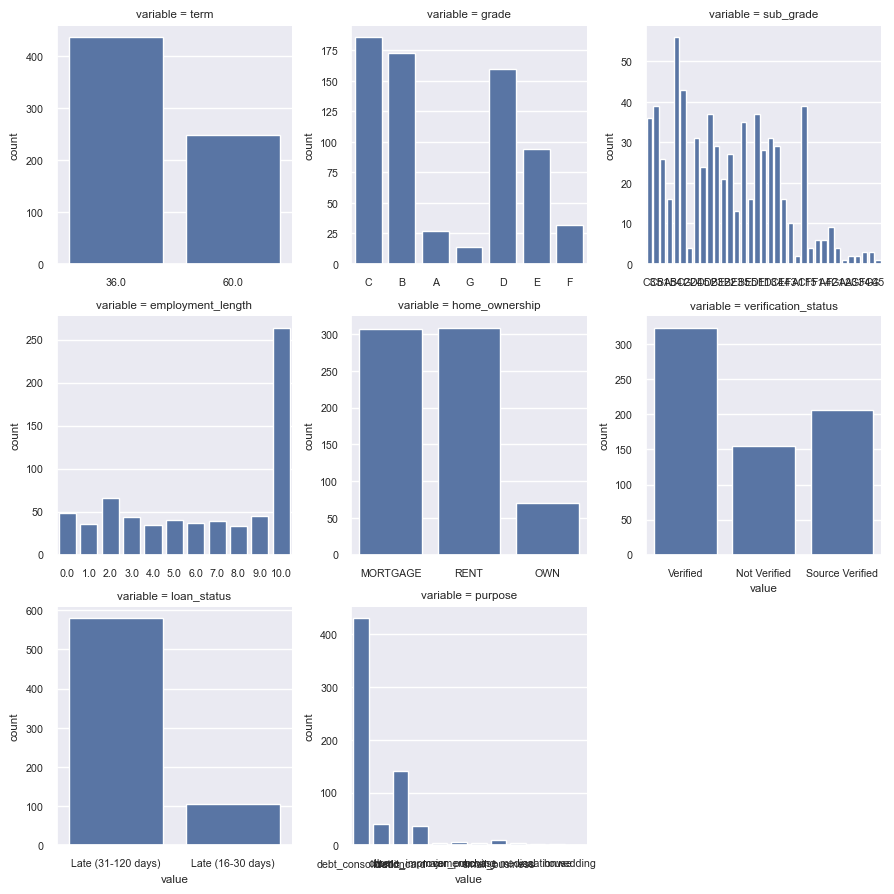

In [94]:
categorical_features_loss = ['term', 'grade', 'sub_grade', 'employment_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose']

plot.Plotter().count_plots(df_loss, categorical_features_loss) 

If we compare the **grade** graph here with the one for the whole dataframe we can observe that:
- Customers with grade `A` are much less frequent in the group of custmers behind on payments.
- Custmoers with grade `G` are still quite frequent in the group of custmers behind on payments.

These could be good indicators of customers falling behing on payments in the future.

We can now use a Chi-Squared test to check to see if there is any trend in the frequency in being `behind payments`, as a function of `grade`.

> The Chi-squared test is a statistical hypothesis test that is used to determine whether there is a significant association between two categorical variables in a sample. We can use the implementation in `scipy.stats`.

In [103]:
from scipy.stats import chi2_contingency

# Step 1: Create a new column indicating whether a customer is behind payments - A
df['behind_payments'] = (df['loan_status'] == 'Late (16-30 days)') | (df['loan_status'] == 'Late (31-120 days)')

# Step 2: Crosstab the new column with B
contingency_table = pd.crosstab(df['behind_payments'], df['grade'] == 'G')

# Step 3: Perform chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic = {chi2}")
print(f"p-value = {p}")

Chi-square statistic = 7.606563753585362
p-value = 0.005815620585928557


Running the code block above, we can see that the `p-value` is lower than 0.05, so we cannot verify the existence of an statistical association between the variables.

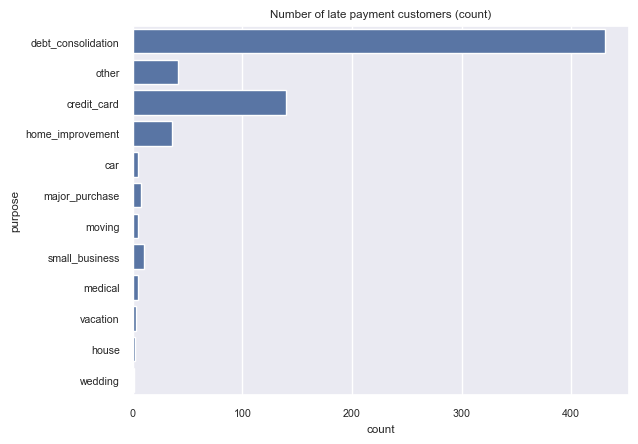

In [96]:
plot.Plotter().count_plot_single(df_loss['purpose'], 'Number of late payment customers (count)') 

The original graph for the whole population sample was: 

> 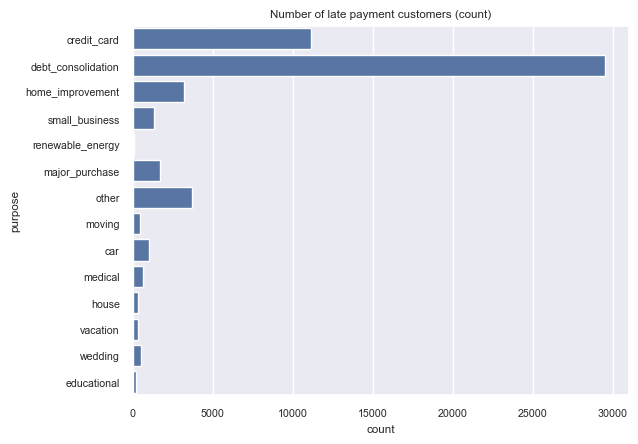

If we compare the **purpose** graph here with the one for the whole dataframe we can observe that:
- Customer that took the loan for the purpose of `debt consolidation` and `credit card` are slightly more frequent in this sub-set of the population

These could be indicators of customers falling behing on payments in the future but it is not evident. Let's test it with the Chi-square:

In [105]:
# Step 1: Create a new column indicating whether a customer is behind payments - A
# DONE IN THE PREVIOUS TEST

# Step 2: Crosstab the new column with B
contingency_table = pd.crosstab(df['behind_payments'], df['purpose'] == 'credit_card')

# Step 3: Perform chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic = {chi2}")
print(f"p-value = {p}")

Chi-square statistic = 0.0018587292337887158
p-value = 0.9656114706267196


For `debt_consolidation` the `p-value` was much lower than 0.05, so we cannot verify the existence of an statistical association between the variables.
However, for `credit_card` the `p-value` was much higher than 0.05, which confirms a statistical association between the variables `behind_payments` and taking a loan with the purpose of `credit_card`.


**Let's now investigate the customers that stopped paying** ('Charged Off' column):

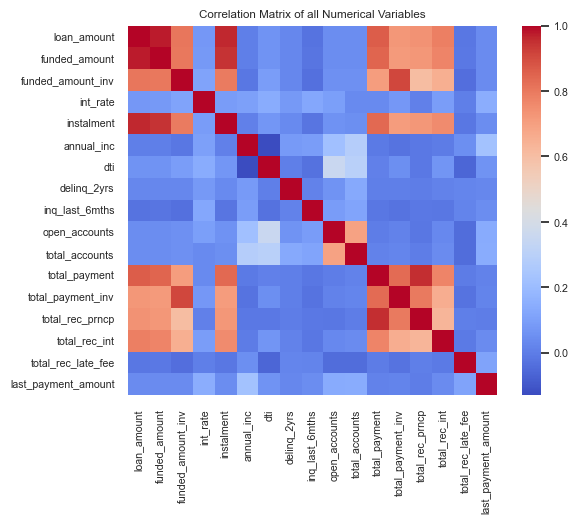

In [98]:

# Create a sub-set of the data for customers that stopped paying:
df_loss = df.loc[df['loan_status'] == 'Charged Off']

# Identify numerical columns:
numeric_features_loss = ['loan_amount', 'funded_amount', 'funded_amount_inv', 'int_rate', 'instalment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_accounts', 'total_accounts', 'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'last_payment_amount']

# Plot correlation matrix for numerical columns
plot.Plotter().correlation_plot(df_loss[numeric_features_loss])

Again, the correlation heatmap does not provide any additional clues of possible indicators for customers that stopped paying.

Let's investigate the categorical variables:

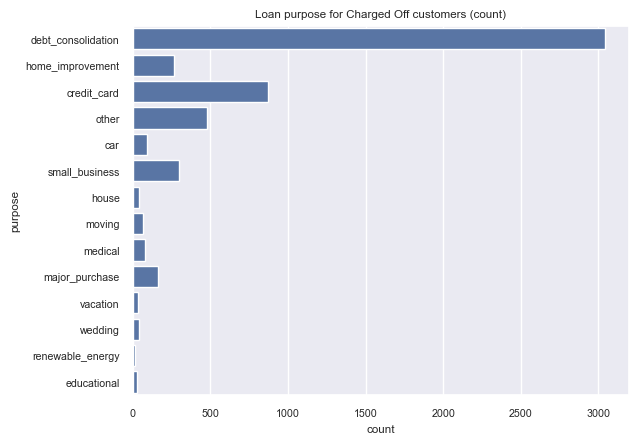

In [99]:
plot.Plotter().count_plot_single(df_loss['purpose'], 'Loan purpose for Charged Off customers (count)') 

From this graph we can see that the frequency of `debt_consolidation` is much higher than the rest, and could possibly be an indicator of customer that stop payments.
Let's check that with the Chi-square test:

In [106]:
# Step 1: Create a new column indicating whether a customer is stopped payments - A
df['stopped_payments'] = (df['loan_status'] == 'Charged Off')

# Step 2: Crosstab the new column with B
contingency_table = pd.crosstab(df['stopped_payments'], df['purpose'] == 'debt_consolidation')

# Step 3: Perform chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic = {chi2}")
print(f"p-value = {p}")

Chi-square statistic = 1.35574454942124
p-value = 0.24427635199961306


In this case, for `debt_consolidation` the `p-value` was much higher than 0.05, which confirms a statistical association between the variables `stopped_payments` and taking a loan with the purpose of `debt_consolidation`.

Let's also test the variable `credit_card`:

In [107]:
# Step 1: Create a new column indicating whether a customer is stopped payments - A
# DONE IN THE PREVIOUS TEST

# Step 2: Crosstab the new column with B
contingency_table = pd.crosstab(df['stopped_payments'], df['purpose'] == 'credit_card')

# Step 3: Perform chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic = {chi2}")
print(f"p-value = {p}")

Chi-square statistic = 81.62536216885721
p-value = 1.6448966543931949e-19


Which indicates that `credit cards` is not a good indicator for customers that stopped payments.

Continuing with our analysis, let's see if `grade` is an indicator of customer that stopped paying:

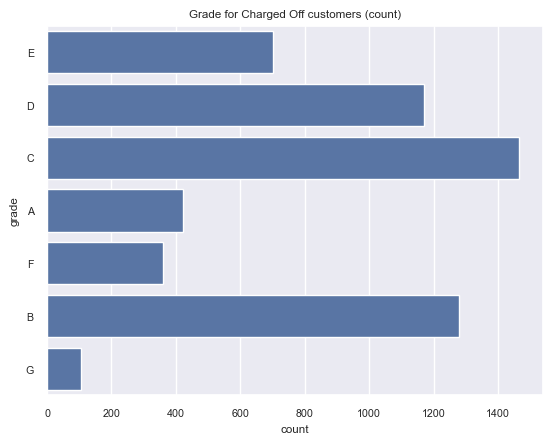

In [100]:
plot.Plotter().count_plot_single(df_loss['grade'], 'Grade for Charged Off customers (count)') 

In [115]:
# Step 1: Create a new column indicating whether a customer is stopped payments - A
# DONE IN THE PREVIOUS TEST

# Step 2: Crosstab the new column with B
contingency_table = pd.crosstab(df['stopped_payments'], df['grade'] == 'G')

# Step 3: Perform chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic = {chi2}")
print(f"p-value = {p}")

Chi-square statistic = 58.36313597082103
p-value = 2.179366260053231e-14


Running the code block above, we can see that the `p-value` is lower than 0.05, so we cannot verify the existence of an statistical association between the variables.

### 6. Summary

In summary, in this analysis I found out that:
- There is a statistical association between the variables `behind_payments` and taking a loan with the purpose of `credit_card`.
- There is a statistical association between the variables `stopped_payments` and taking a loan with the purpose of `debt_consolidation`.

This means that new customers that take loans with the purpose of 'credit card' are likely to become late in their payments (credit card as an indicator). And new customers that take loans with the purpose of 'debt_consolidation' are more likely to stop their payments than other types of customers (debt consolidation as an indicator).
